# Dependencies

In [1]:
pacman::p_load(dplyr)

# Functions

In [2]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")

# Paths

In [3]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [4]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

bind all metadata

In [5]:
meta_div <- readr::read_rds(file = paste0(datapath,"capTCRseq/meta_div_goodsamples.rds"))

In [6]:
colnames(meta_div)

[1] "sample_id"          "Patient"            "cycle"             
 [4] "FOLD"               "ATC"                "Age"               
 [7] "Disease_type"       "TE_fold"            "Pass"              
[10] "CD3"                "EM"                 "CM"                
[13] "Na<U+00EF>ve"       "SCM"                "TE"                
[16] "EM."                "CM."                "Na<U+00EF>ve."     
[19] "SCM."               "TE."                "Na<U+00EF>ve.TE"   
[22] "N.CM.SCM.TE.EM"     "PD.1"               "PDL1"              
[25] "LAG3"               "TIM3"               "CTLA4"             
[28] "PD1."               "PDL1."              "LAG3."             
[31] "TIM3."              "CTLA4."             "Any.NCR"           
[34] "PD1...LAG3...TIM3"  "cancergroup"        "TRB"               
[37] "Reads"              "CPKR"               "Average_reads"     
[40] "VMR"                "Max_reads"          "Singletons"        
[43] "Doubletons"         "qD"                 "Sample_Coverage"   
[46] "observed_Richness"  "estimated_Richness" "SE_Richeness"      
[49] "observed_Shannon"   "estimated_Shannon"  "SE_Shannon"        
[52] "observed_Simpson"   "estimated_Simpson"  "SE_Simpson"        
[55] "file"               "basename"           "Group"             
[58] "sampletype"

In [7]:
subset_meta <- meta_div[, c("Patient", "cycle", "FOLD", "Disease_type", 
"CD3", "cancergroup", "sampletype", "TRB", "Age")]

In [58]:
subset_meta[ subset_meta$Patient == "CHP_341", ]

,Patient,cycle,FOLD,Disease_type,CD3,cancergroup,sampletype,TRB,Age
,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
133,CHP_341,2,0,CML,0,Leukemia,cfDNA,34,12


In [8]:
# recode cycle to numeric
subset_meta$cycle <- gsub("X", "", subset_meta$cycle)

In [9]:
subset_meta$cycle <- as.numeric(subset_meta$cycle)

In [10]:
table(subset_meta$sampletype, useNA = "ifany")


 PBMC Tumor cfDNA  <NA> 
  248    18   261   256 

In [11]:
#remove Tumor samples
subset_meta <- subset_meta[ which(subset_meta$sampletype != "Tumor"),]
#remove Normal samples
subset_meta <- subset_meta[ which(subset_meta$cancergroup != "Normal"),]
# remove LFS samples
subset_meta <- subset_meta[which(subset_meta$cancergroup != "LFS"),]

In [40]:
mydat <- matrix(ncol = 20, nrow = length(unique(subset_meta$Patient)))
rownames(mydat) <- unique(subset_meta$Patient)
# assign colnames 5 PBMCs, 5 cfDNA, 5 FOLD,  5 CD3 separate by _
colnames(mydat) <- c(paste0(rep("PBMC_", 5), 1:5),
                        paste0(rep("cfDNA_", 5), 1:5),
                        paste0(rep("FOLD_", 5), 1:5),
                        paste0(rep("CD3_", 5), 1:5))

In [41]:
datatype.fx <- function(x){

x$datatype <- NA
for(i in 1:nrow(x)){
#if is.na(TRB) & !is.na(FOLD) & !is.na(CD3), then datatype = FOLD,CD3
    if(is.na(x$TRB[i]) & !is.na(x$FOLD[i]) & !is.na(x$CD3[i])){
        x$datatype[i] <- paste0("FOLD", "_",x$cycle[i], ",", "CD3","_", x$cycle[i])
    }
#if is.na(TRB) & !is.na(CD3) & is.na(FOLD), then datatype = CD3
    if(is.na(x$TRB[i]) & !is.na(x$CD3[i]) & is.na(x$FOLD[i])){
        x$datatype[i] <- paste0("CD3","_", x$cycle[i])
    }
#if is.na(TRB) & is.na(CD3) & !is.na(FOLD), then datatype = FOLD
    if(is.na(x$TRB[i]) & !is.na(x$FOLD[i]) & is.na(x$CD3[i])){
        x$datatype[i] <- paste0("FOLD","_", x$cycle[i])
    }
#if !is.na(TRB) & !is.na(CD3) & is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, CD3
    if(!is.na(x$TRB[i]) & !is.na(x$CD3[i]) & is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "CD3","_", x$cycle[i])
    }

#if !is.na(TRB) & is.na(CD3) & !is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, FOLD
    if(!is.na(x$TRB[i]) & is.na(x$CD3[i]) & !is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "FOLD","_", x$cycle[i])
    }

#if !is.na(TRB) & & !is.na(CD3) & !is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, FOLD, CD3
    if(!is.na(x$TRB[i]) & !is.na(x$CD3[i]) & !is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "FOLD","_", x$cycle[i], ",", "CD3","_", x$cycle[i])
    }
#if sampletype == "cfDNA", then datatype = cfDNA
    if(x$sampletype[i] == "cfDNA"){
        x$datatype[i] <- paste0("cfDNA","_", x$cycle[i])
    }
}

# separate_rows based on , in datatype_cycle
x_s <- x %>% tidyr::separate_rows(datatype, sep = ",")

pw <- tidyr::pivot_wider(x_s[, c("Patient", "datatype", "Age")], 
names_from = datatype, values_from = Age)

pw <- as.data.frame(pw)
rownames(pw) <- pw$Patient
pw$Patient <- NULL

# match colnames(pw) with colnames(mydat), pw$Patient with rownames(mydat)
mydat[ rownames(pw), colnames(pw)] <- as.matrix(pw) 
#print(pw)
return(mydat)
}

In [42]:
for(p in unique(subset_meta$Patient)){
    x <- subset_meta[subset_meta$Patient == p, ]
    mydat <- datatype.fx(x)
}

In [45]:
head(mydat)

,PBMC_1,PBMC_2,PBMC_3,PBMC_4,PBMC_5,cfDNA_1,cfDNA_2,cfDNA_3,cfDNA_4,cfDNA_5,FOLD_1,FOLD_2,FOLD_3,FOLD_4,FOLD_5,CD3_1,CD3_2,CD3_3,CD3_4,CD3_5
CHP_323,NA,NA,1.0,NA,1,NA,NA,1,NA,1.0,NA,NA,1.0,NA,1,NA,NA,1.0,NA,1
CHP_324,NA,NA,NA,NA,12,NA,NA,NA,12.0,12.0,NA,NA,NA,NA,12,NA,NA,NA,NA,12
CHP_328,NA,NA,NA,7,7,NA,NA,NA,NA,7.0,NA,NA,NA,7,7,NA,NA,NA,7,7
CHP_330,NA,NA,NA,NA,5,NA,NA,NA,5.0,NA,NA,NA,NA,NA,5,NA,NA,NA,NA,5
CHP_331,NA,NA,NA,5,5,NA,NA,NA,NA,5.0,NA,NA,NA,5,5,NA,NA,NA,5,5
CHP_335,NA,NA,0.9,NA,NA,NA,NA,NA,0.9,0.9,NA,NA,0.9,NA,NA,NA,NA,0.9,NA,NA


In [43]:
mydat_m <- reshape2::melt(mydat, na.rm = TRUE)

In [44]:
mydat_m$cycle <- gsub(".*_", "", mydat_m$Var2)
mydat_m$Datatype <- gsub("_.*", "", mydat_m$Var2)

In [46]:
mydat_m$cycle <- as.factor(mydat_m$cycle)

In [47]:
mydat_m$cancergroup <- subset_meta$cancergroup[match(mydat_m$Var1, subset_meta$Patient)]

In [48]:
summary(mydat_m$cycle)

1   2   3   4   5 
181 218 204 168 160

In [49]:
patients_cycles <- cbind.data.frame( unique(mydat_m$Var1), "5")
colnames(patients_cycles) <- c("Patient", "cycle")

patients_cycles$cancergroup <- subset_meta$cancergroup[match(patients_cycles$Patient, subset_meta$Patient)]

In [50]:
head(patients_cycles)

,Patient,cycle,cancergroup
,<fct>,<chr>,<chr>
1,CHP_346,5,Solid
2,CHP_347,5,Leukemia
3,CHP_348,5,Solid
4,CHP_349,5,Leukemia
5,CHP_350,5,Solid
6,CHP_352,5,Leukemia


In [51]:
patients_cycles$Patient <- as.character(patients_cycles$Patient)

#patients_cycles <- patients_cycles[order(patients_cycles$cancergroup),]

In [52]:
patients_cycles$Patient <- factor(patients_cycles$Patient, levels = patients_cycles$Patient[order(patients_cycles$cancergroup)])

In [53]:
mydat_m$Var1 <- factor(mydat_m$Var1, levels = levels(patients_cycles$Patient))

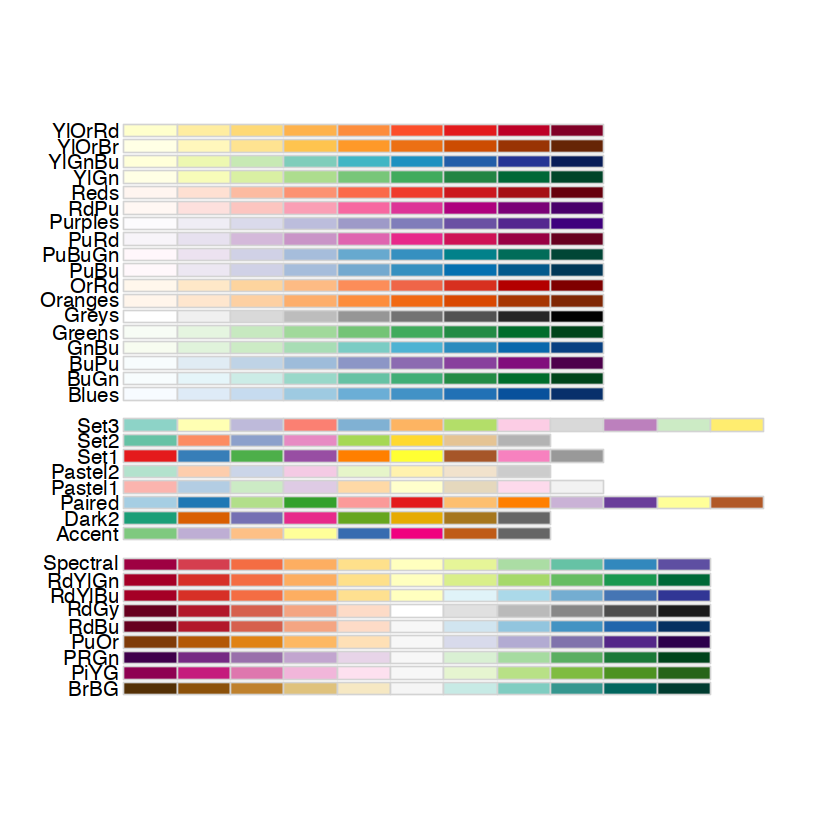

In [54]:
RColorBrewer::display.brewer.all(colorblindFriendly = F)  

In [55]:
p0 <- ggplot( patients_cycles, aes(Patient, cycle)) +
  geom_bar(stat="identity", aes(fill=cancergroup), width=0.7, alpha = 0.2) +
  geom_jitter(data=mydat_m,aes(Var1, cycle, colour = Datatype, shape=Datatype), size=3, width=0, height=0.1) +
  coord_flip() +
  scale_fill_manual(values= group_col[c("Leukemia", "Lymphoma", "Solid")]) +
  scale_color_brewer(palette = "Set1")+
  scale_shape_manual(values=c(15,16,17,18)) +
  #scale_y_continuous(limits=c(-1,20), breaks=0:20) +
  #labs(fill="Disease Stage", colour="", shape="", x="Subject Recevied Study Drug") +
  myplot + theme(legend.position="right")

In [56]:
pdf(paste0(plotpath,"test.pdf"), width=10, height=10)
p0
dev.off()

pdf 
  2

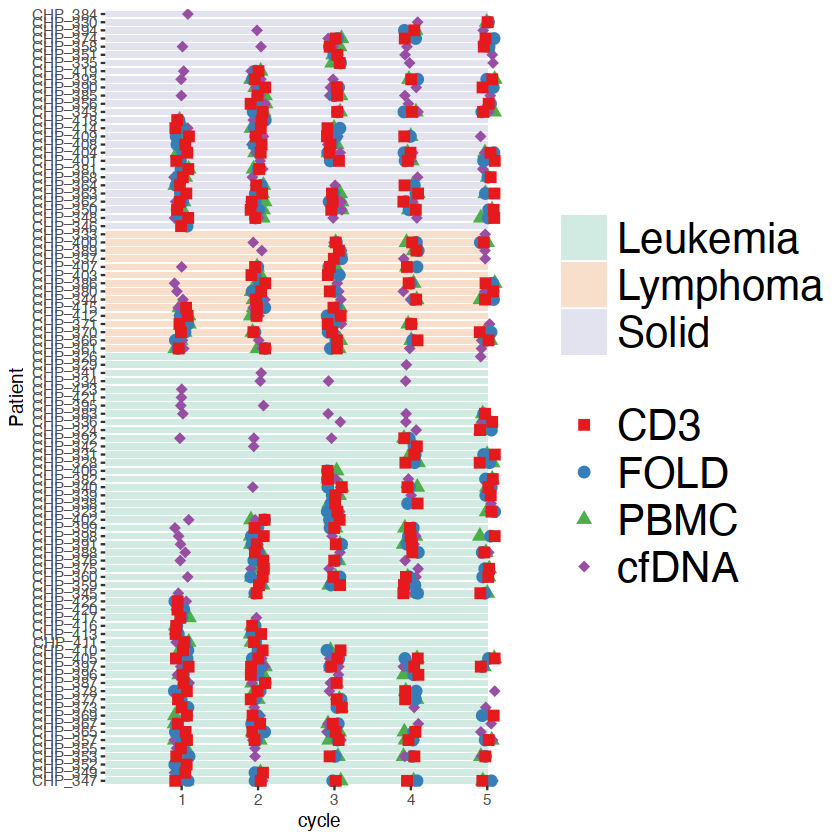

In [57]:
p0